# CSC413 Project: Toxicity Detector

Given the current state of content moderation at social media and gaming companies, it is easy to understand why the systems either seem lax or overdone. Automated content moderation is employed, but is usually too lax or too aggressive to effectively moderate. Many companies outsource moderation as low paying-jobs, which realistically can never keep up with the current output of content. There are 510,000 Facebook comments made per minute alone presenting a need for effective automated moderation. This high financial barrier to entry also makes it harder for new companies to enter the market, making a less competitive market overall.To combat this problem, a deep learning model will be designed to classify different types of toxic2 comments. While the model can not fully capture the nuances of human conversation, the expectation is to cover a majority of blatant cases with a quick and flexible solution. Allowing human moderators to deal with the more complicated cases.

## Data

We will begin by downloading the data onto Google Colab from kaggle. The data is retrieved from https://www.kaggle.com/datasets/fizzbuzz/cleaned-toxic-comments

In [2]:
!pip install kaggle

In [4]:
from google.colab import files
files.upload() # Upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadhamza0403","key":"0833d946374c60adcb595bd0c1254b8c"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d fizzbuzz/cleaned-toxic-comments
! unzip cleaned-toxic-comments.zip

 76% 33.0M/43.7M [00:00<00:00, 109MB/s] 
100% 43.7M/43.7M [00:00<00:00, 105MB/s]
Archive:  cleaned-toxic-comments.zip
  inflating: test_preprocessed.csv   
  inflating: train_preprocessed.csv  


## Data Analysis and Processing
We will analyze the type and amount of data that we will work with and introduce a validation set. From the dataset we can see that there are toxicity labels ranging from 0-6 and for the purposes of the analysis samples from 0-2 are displayed

In [157]:
import pandas as pd
df_train = pd.read_csv('/content/train_preprocessed.csv')

# Randomly split the train set into a 15% test 15% validation and 70% train set
df_val = df_train.sample(n=int(len(df_train) * 0.30))
df_train = df_train.drop(df_val.index)

df_test = df_val.sample(n=int(len(df_val) * 0.50))
df_val = df_val.drop(df_test.index)

# First few samples in the data set of each toxicity level
print(df_train.head())
print(df_train[df_train['toxicity']==0.0].head())
print(df_train[df_train['toxicity']==1.0].head())
print(df_train[df_train['toxicity']==2.0].head())

                                        comment_text                id  \
0  explanation why the edits made under my userna...  0000997932d777bf   
1  d aww  he matches this background colour i m s...  000103f0d9cfb60f   
3    more i can t make any real suggestions on im...  0001b41b1c6bb37e   
4  you  sir  are my hero  any chance you remember...  0001d958c54c6e35   
5   congratulations from me as well  use the tool...  00025465d4725e87   

   identity_hate  insult  obscene    set  severe_toxic  threat  toxic  \
0            0.0     0.0      0.0  train           0.0     0.0    0.0   
1            0.0     0.0      0.0  train           0.0     0.0    0.0   
3            0.0     0.0      0.0  train           0.0     0.0    0.0   
4            0.0     0.0      0.0  train           0.0     0.0    0.0   
5            0.0     0.0      0.0  train           0.0     0.0    0.0   

   toxicity  
0       0.0  
1       0.0  
3       0.0  
4       0.0  
5       0.0  
                                

In [9]:
training_samples = len(df_train)
val_samples = len(df_val)
testing_samples = len(df_test)
print(f'Train samples: {training_samples}')
print(f'Validation samples: {val_samples}')
print(f'Test samples: {testing_samples}')

Train samples: 111700
Validation samples: 47871
Test samples: 153164


Now we will extract the comment and label pairs from the data frame. The data frame includes much more information than needed for training

In [158]:
import random

# read the data; convert labels into integers
train_data = [(row.comment_text, row.toxicity)
            for row in df_train.itertuples(index=False)]

# read the data; convert labels into integers
val_data = [(row.comment_text, row.toxicity)
            for row in df_val.itertuples(index=False)]

# read the data; convert labels into integers
test_data = [(row.comment_text, row.toxicity)
            for row in df_test.itertuples(index=False)]

random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

Create tokenization for the comments so that they can be trained, taken for CSC413 Lab10

In [159]:
import torchtext

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, build_vocab_from_iterator

# we will *tokenize* each word by using a tokenzier from
# https://pytorch.org/text/stable/data_utils.html#get-tokenizer

tokenizer = get_tokenizer("basic_english")
token_data_words = [tokenizer(row.comment_text) for row in df_train.itertuples(index=False)]
# build the vocabulary object. the parameters to this function
# is described below
vocab = build_vocab_from_iterator(token_data_words,
                                  specials=['<bos>', '<eos>', '<unk>', '<pad>'],
                                  min_freq=10)

# set the index of a word not in the vocabulary
vocab.set_default_index(2) # this is the index of the `<unk>` keyword

Setting up the glove embeddings as outlined in the model architecture.

In [13]:
from torchtext.vocab import GloVe

glove = torchtext.vocab.GloVe(name="6B", dim=300)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [01:03<00:00, 6253.65it/s]


In [161]:
def convert_indices(data, default=len(glove)-1):
    result = []
    for text, label in data:
        words = tokenizer(text) # for simplicity, we wont use <bos> and <eos>
        indices = []
        for w in words:
            if w in glove.stoi:
                indices.append(glove.stoi[w])
            else:
                # this is a bit of a hack, but we will repurpose *last* word
                # (least common word) appearing in the GloVe vocabluary as our
                # '<pad>' token
                indices.append(default)
        result.append((indices, label),)
    return result

train_data_indices = convert_indices(train_data)
val_data_indices = convert_indices(val_data)
test_data_indices = convert_indices(test_data)

In [162]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    """
    Returns the input and target tensors for a batch of data

    Parameters:
        `batch` - An iterable data structure of tuples (indices, label),
                  where `indices` is a sequence of word indices, and
                  `label` is either 1 or 0.

    Returns: a tuple `(X, t)`, where
        - `X` is a PyTorch tensor of shape (batch_size, sequence_length)
        - `t` is a PyTorch tensor of shape (batch_size)
    where `sequence_length` is the length of the longest sequence in the batch
    """

    text_list = []  # collect each sample's sequence of word indices
    label_list = [] # collect each sample's target labels
    for (text_indices, label) in batch:
        text_list.append(torch.tensor(text_indices))
        label_list.append(torch.tensor(label))

    X = pad_sequence(text_list, padding_value=3).transpose(0, 1)
    t = torch.tensor(label_list)
    return X, t


train_dataloader = DataLoader(train_data_indices, batch_size=10, shuffle=True,
                              collate_fn=collate_batch)

## Part 2: Model
To set up the LSTM the nn.LSTM class is used. Then everything is fed into a fully connected layer. This layer will have the data that has been accumulated by the hidden layers of the RNN. Then using this data the prediction will be the highest class. The predication is a number between 0-6 that represents the toxicity level of a given comment.

In [163]:
import torch.nn as nn

class LSTMToxicityModel(nn.Module):
    def __init__(self,  hidden_size, num_classes):
        super(LSTMToxicityModel, self).__init__()
        self.vocab_size, self.emb_size = glove.vectors.shape
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.emb.requires_grad=False # do *not* update the glove embeddings
        self.rnn = nn.LSTM(self.emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, X):
        # Look up the embedding
        wordemb = self.emb(X)
        # Forward propagate the RNN
        h, out = self.rnn(wordemb)
        # combine the hidden features computed from *each* time step of
        # the RNN. we do this by
        features = torch.cat([torch.amax(h, dim=1),
                              torch.mean(h, dim=1)], axis=-1)
        # Compute the final prediction
        z = self.fc(features)
        return z

    def parameters(self):
        # do not return the parameters of self.emb
        # so the optimizer will not update the parameters of self.emb
        return (p for p in super(LSTMToxicityModel, self).parameters() if p.requires_grad)


model = LSTMToxicityModel(64, 2)

In [164]:
def accuracy(model, dataset, max=1000):
    """
    Estimate the accuracy of `model` over the `dataset`.
    We will take the **most probable class**
    as the class predicted by the model.

    Parameters:
        `model`   - An object of class nn.Module
        `dataset` - A dataset of the same type as `train_data`.
        `max`     - The max number of samples to use to estimate
                    model accuracy

    Returns: a floating-point value between 0 and 1.
    """

    correct, total = 0, 0
    dataloader = DataLoader(dataset,
                            batch_size=1,  # use batch size 1 to prevent padding
                            collate_fn=collate_batch)
    for i, (x, t) in enumerate(dataloader):
        z = model(x)
        y = torch.argmax(z, axis=1)
        correct += int(torch.sum(t == y))
        total   += 1
        if i >= max:
            break
    return correct / total

accuracy(model, train_data_indices)

0.03996003996003996

##Part 3: Training
The training function is the standard function used throughout the labs, it uses cross entropy loss and the Adam optimizer. Finally it plots the loss and accuracy after the training is complete

In [165]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model,                # an instance of MLPModel
                train_data,           # training data
                val_data,             # validation data
                learning_rate=0.001,
                batch_size=100,
                num_epochs=10,
                plot_every=50,        # how often (in # iterations) to track metrics
                plot=True):           # whether to plot the training curve
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate_batch,
                                               shuffle=True) # reshuffle minibatches every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for e in range(num_epochs):
            for i, (texts, labels) in enumerate(train_loader):
                z = model(texts)
                loss = criterion(z, labels.long())

                loss.backward() # propagate the gradients
                optimizer.step() # update the parameters
                optimizer.zero_grad() # clean up accumualted gradients

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    ta = accuracy(model, train_data)
                    va = accuracy(model, val_data)
                    train_loss.append(float(loss))
                    train_acc.append(ta)
                    val_acc.append(va)
                    print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)
    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)], train_loss)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend(["Train", "Validation"])

1 Loss: 2.00233793258667 Train Acc: 0.0 Val Acc: 0.0
2 Loss: 1.872342824935913 Train Acc: 0.3 Val Acc: 0.2
3 Loss: 1.744368314743042 Train Acc: 0.8 Val Acc: 0.85
4 Loss: 1.6170921325683594 Train Acc: 0.85 Val Acc: 0.95
5 Loss: 1.4907417297363281 Train Acc: 0.85 Val Acc: 1.0
6 Loss: 1.3689689636230469 Train Acc: 0.85 Val Acc: 1.0
7 Loss: 1.2543766498565674 Train Acc: 0.85 Val Acc: 1.0
8 Loss: 1.1481239795684814 Train Acc: 0.85 Val Acc: 1.0
9 Loss: 1.0509783029556274 Train Acc: 0.85 Val Acc: 1.0
10 Loss: 0.9639472961425781 Train Acc: 0.85 Val Acc: 1.0


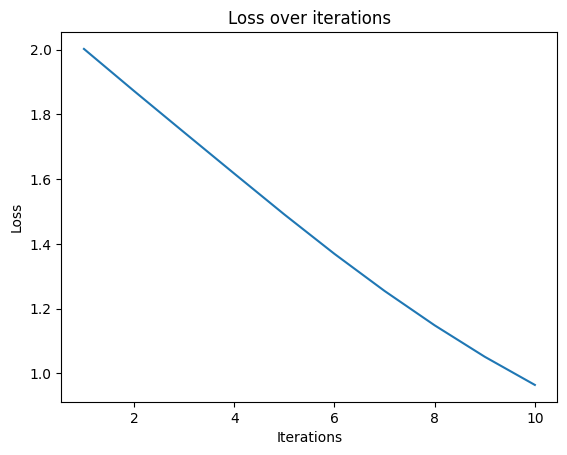

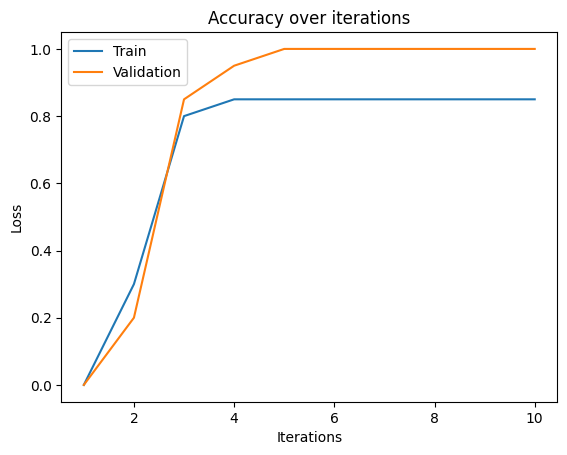

In [166]:
model = LSTMToxicityModel(
              hidden_size=64,
              num_classes=7)

train_model(model, train_data_indices[:20], val_data_indices[:20], plot_every=1)

1 Loss: 0.26520130038261414 Train Acc: 0.935 Val Acc: 0.845
2 Loss: 0.2654213607311249 Train Acc: 0.94 Val Acc: 0.885
3 Loss: 0.18096697330474854 Train Acc: 0.925 Val Acc: 0.905
4 Loss: 0.17925260961055756 Train Acc: 0.93 Val Acc: 0.9
5 Loss: 0.17116135358810425 Train Acc: 0.94 Val Acc: 0.875


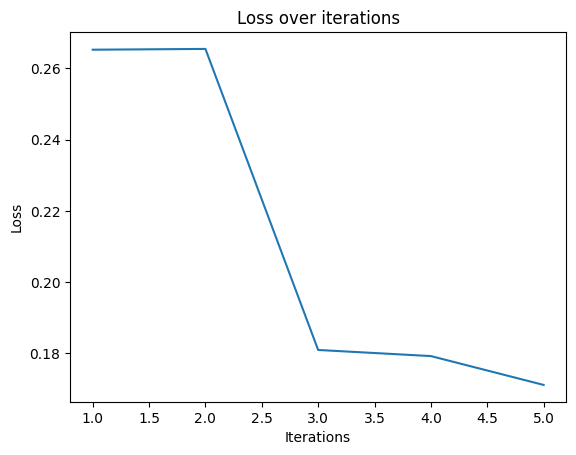

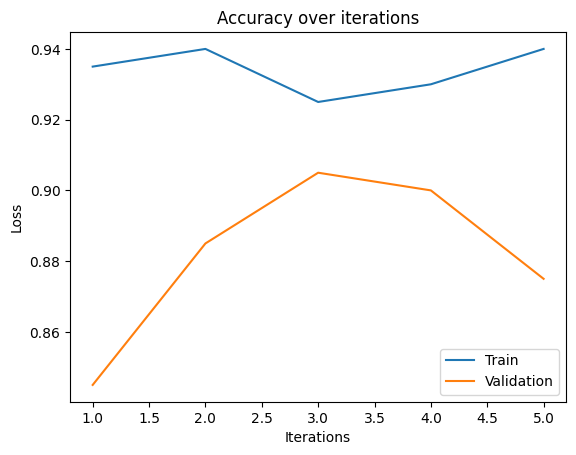

In [172]:
train_model(model,
            train_data_indices[:200],
            val_data_indices[:200],
            learning_rate=0.02,
            batch_size=200,
            num_epochs=5,
            plot_every=1)

There seems to be some overfitting from the data, the following section on data augmentation aims to fix this overfitting.

<Figure size 640x480 with 0 Axes>

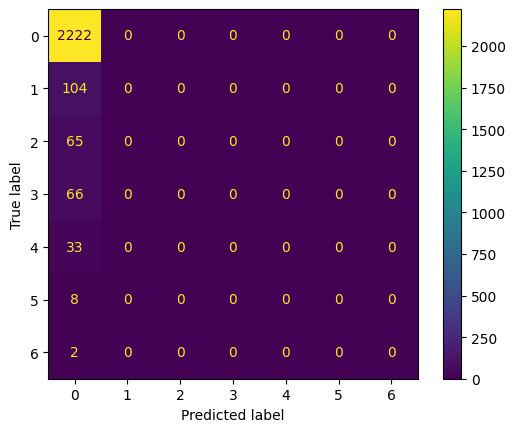

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sklearn
label = "0123456"
def plot_confusion(model, data):
    data = torch.utils.data.DataLoader(data,
                                        batch_size=100,
                                        collate_fn=collate_batch,
                                        shuffle=True)
    ts = []
    ys = []
    model.to('cpu')
    for x, t in data:
        z = model(x)
        ts.extend(t.to(torch.int).tolist())
        ys.extend(torch.argmax(z, axis=1).tolist())

    cm = confusion_matrix(ts, ys)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
    plt.figure()
    disp.plot()

plot_confusion(model, train_data_indices[:2500])

<Figure size 640x480 with 0 Axes>

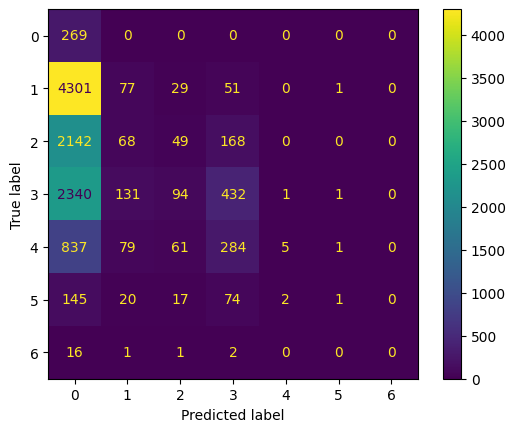

In [212]:
df = df_train.drop(df_train[df_train['toxicity'] == 0].sample(100000).index)
plot_confusion(model, convert_indices([(row.comment_text, row.toxicity)
            for row in df.itertuples(index=False)]))

#Part 4: Data Augmentation
From the results above it is evident that most of the samples are being classified as 0 due to the lack of negative comments. As a result, more data poitns can be added by simply swapping a toxic comment with a close enough word to introduce more data. This gives the model more toxic comments to work with and will prevent it from classifying many false positives.

In [173]:
def get_closest_word(vec):
    dists = torch.norm(glove.vectors - vec, dim=1)     # compute distances to all words
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1]) # sort by distance
    return glove.itos[lst[-1][0]]

In [174]:
def augment(df):
  """ Adds 20 more data points for each data point by slightly
      changing the words in the comment.
  """
  new_data = []
  for row in df:
    text = row.comment_text
    text = text.split(" ")
    if row.toxicity != 0:
        word = random.randint(0, len(text) - 1)
        text[word] = get_closest_word(glove[text[word]])
        new_data.append((" ".join(text), row.toxicity))
  return new_data


In [175]:
# read the data; convert labels into integers
train_data = [(row.comment_text, row.toxicity)
            for row in df_train.itertuples(index=False)]

# read the data; convert labels into integers
val_data = [(row.comment_text, row.toxicity)
            for row in df_val.itertuples(index=False)]

train_data.extend(augment(df_train.sample(2000).itertuples(index=False)))

train_data_indices = convert_indices(train_data)
val_data_indices = convert_indices(val_data)
random.shuffle(train_data_indices)
random.shuffle(val_data_indices)

1 Loss: 0.522853672504425 Train Acc: 0.795 Val Acc: 0.79
2 Loss: 0.4735536575317383 Train Acc: 0.8375 Val Acc: 0.81
3 Loss: 0.2782016396522522 Train Acc: 0.875 Val Acc: 0.8575
4 Loss: 0.38270026445388794 Train Acc: 0.88 Val Acc: 0.8725
5 Loss: 0.20349980890750885 Train Acc: 0.8975 Val Acc: 0.8775
6 Loss: 0.2933765947818756 Train Acc: 0.9 Val Acc: 0.8775
7 Loss: 0.21438218653202057 Train Acc: 0.9075 Val Acc: 0.8725
8 Loss: 0.20803424715995789 Train Acc: 0.905 Val Acc: 0.88
9 Loss: 0.19643953442573547 Train Acc: 0.915 Val Acc: 0.89
10 Loss: 0.13836978375911713 Train Acc: 0.925 Val Acc: 0.8925


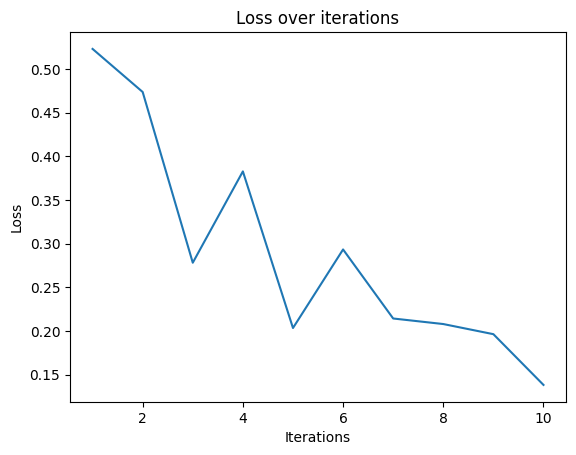

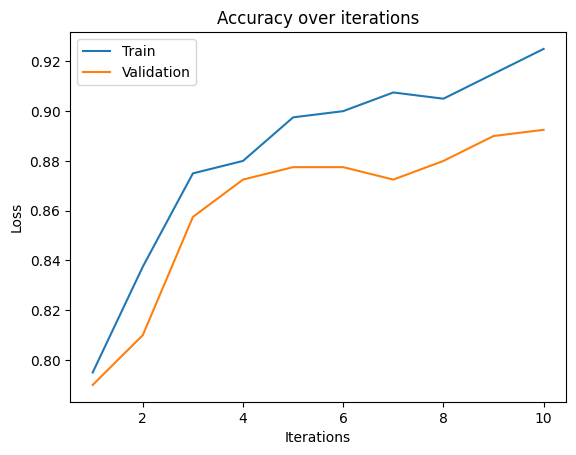

In [176]:
train_model(model,
            train_data_indices[:400],
            val_data_indices[:400],
            learning_rate=0.02,
            batch_size=200,
            num_epochs=5,
            plot_every=1)

<Figure size 640x480 with 0 Axes>

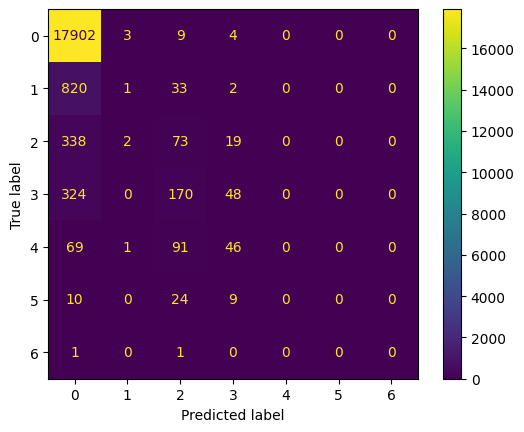

<Figure size 640x480 with 0 Axes>

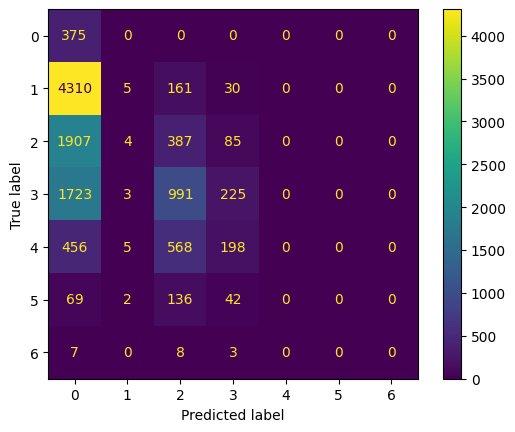

In [150]:
# Plotting the confusion with the excessive zeros and without them
plot_confusion(model, train_data_indices[:20000])

df = df_train.drop(df_train[df_train['toxicity'] == 0].sample(100000).index)
plot_confusion(model, convert_indices([(row.comment_text, row.toxicity)
            for row in df.itertuples(index=False)]))

The confusion matrices show that there is starting to be more non toxic comments detected especially in the 2-4 range after adding in these points. This may help in increasing the validation accuracy further by detecting patterns and key words in the toxic comments.

In [177]:
# Final Test Accuracy
accuracy(model, test_data_indices)

0.8801198801198801

In [210]:
def test_model(comment):
  index = convert_indices([(comment, -1)])
  X, _ = collate_batch(index)
  return torch.argmax(model(X)).item()

print(f'Toxicity Score: {test_model("im doing great")}')
print(f'Toxicity Score: {test_model("ugly")}')

Toxicity Score: 0
Toxicity Score: 3
